In [1]:
import time
import numba as nb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

from typing import Tuple

np.random.seed(42)
colors = ['skyblue', 'indianred']

In [2]:
def generate_linear_data() -> Tuple[np.ndarray, np.ndarray]:
    """ Generate random linear data to test our Kalman Filter implementation.
    """
    x = np.linspace(0, 10, 100)
    y = 1.8 * x -3.21 + np.random.normal(0, 1, size=x.shape)

    x = x.reshape(-1, 1)
    x = np.hstack([np.ones((x.shape[0], 1)), x])
    return x, y

def generate_quad_data() -> Tuple[np.ndarray, np.ndarray]:
    """ Generate random quadratic data to test our Kalman Filter implementation.
    """
    x = np.linspace(0, 10, 100)
    y = 1.8 * x - 0.7 * x**2 - 3.21 + np.random.normal(0, 1, size=x.shape)

    x = x.reshape(-1, 1)
    x = np.hstack([np.ones((x.shape[0], 1)), x])
    return x, y

def linear_reg(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """ Perform linear regression using the Normal Equation.
    """
    return np.linalg.inv(X.T @ X) @ X.T @ Y

In [3]:
xl, yl = generate_linear_data()

In [4]:
xq, yq = generate_quad_data()

## <font color='cornflowerblue'> Linear Regression

Linear Regression MSE: 0.8149
Linear Regression R^2: 0.9717


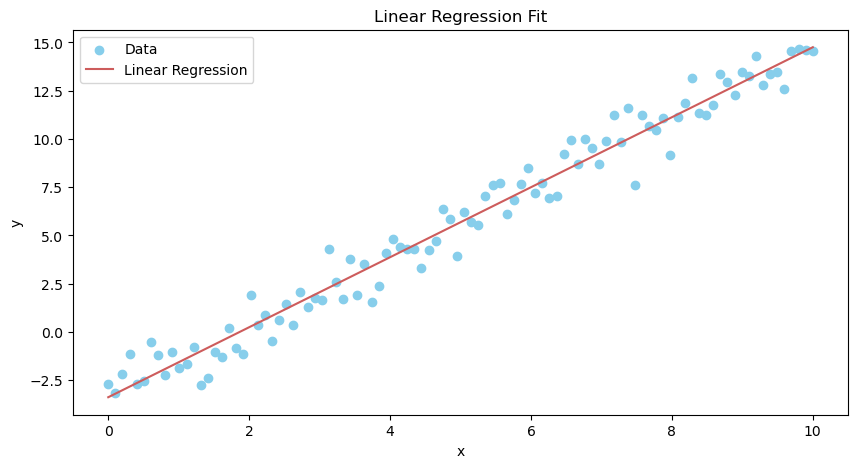

In [5]:
w_linear = linear_reg(xl, yl)
y_pred_linear = xl @ w_linear
e_linear = mean_squared_error(yl, y_pred_linear)
r2_linear = r2_score(yl, y_pred_linear)

print(f'Linear Regression MSE: {e_linear:.4f}')
print(f'Linear Regression R^2: {r2_linear:.4f}')

plt.figure(figsize=(10, 5))
plt.scatter(xl[:,1], yl, label='Data', color='skyblue')
plt.plot(xl[:,1], y_pred_linear, label='Linear Regression', color='indianred')
plt.title('Linear Regression Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Quadratic Regression MSE: 30.1827
Quadratic Regression R^2: 0.8839


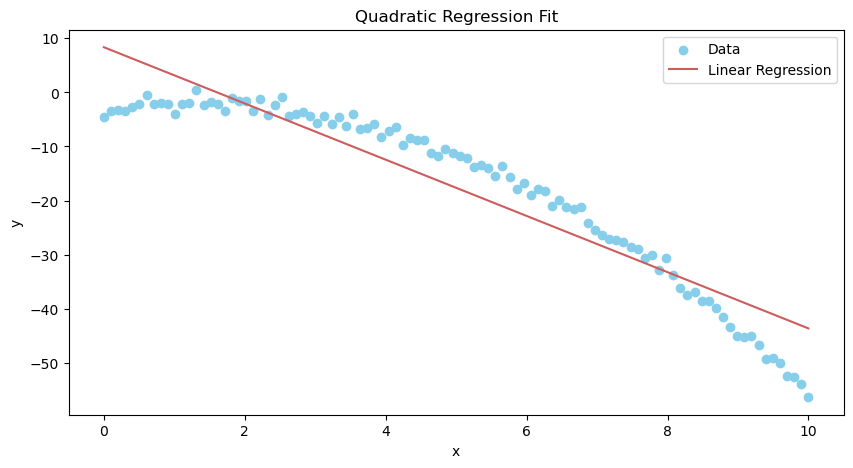

In [6]:
w_quad = linear_reg(xq, yq)
y_pred_quad = xq @ w_quad
e_quad = mean_squared_error(yq, y_pred_quad)
r2_quad = r2_score(yq, y_pred_quad)
print(f'Quadratic Regression MSE: {e_quad:.4f}')
print(f'Quadratic Regression R^2: {r2_quad:.4f}')

plt.figure(figsize=(10, 5))
plt.scatter(xq[:,1], yq, label='Data', color='skyblue')
plt.plot(xq[:,1], y_pred_quad, label='Linear Regression', color='indianred')
plt.title('Quadratic Regression Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## <font color='cornflowerblue'> Linear Regression with Kalman Filters

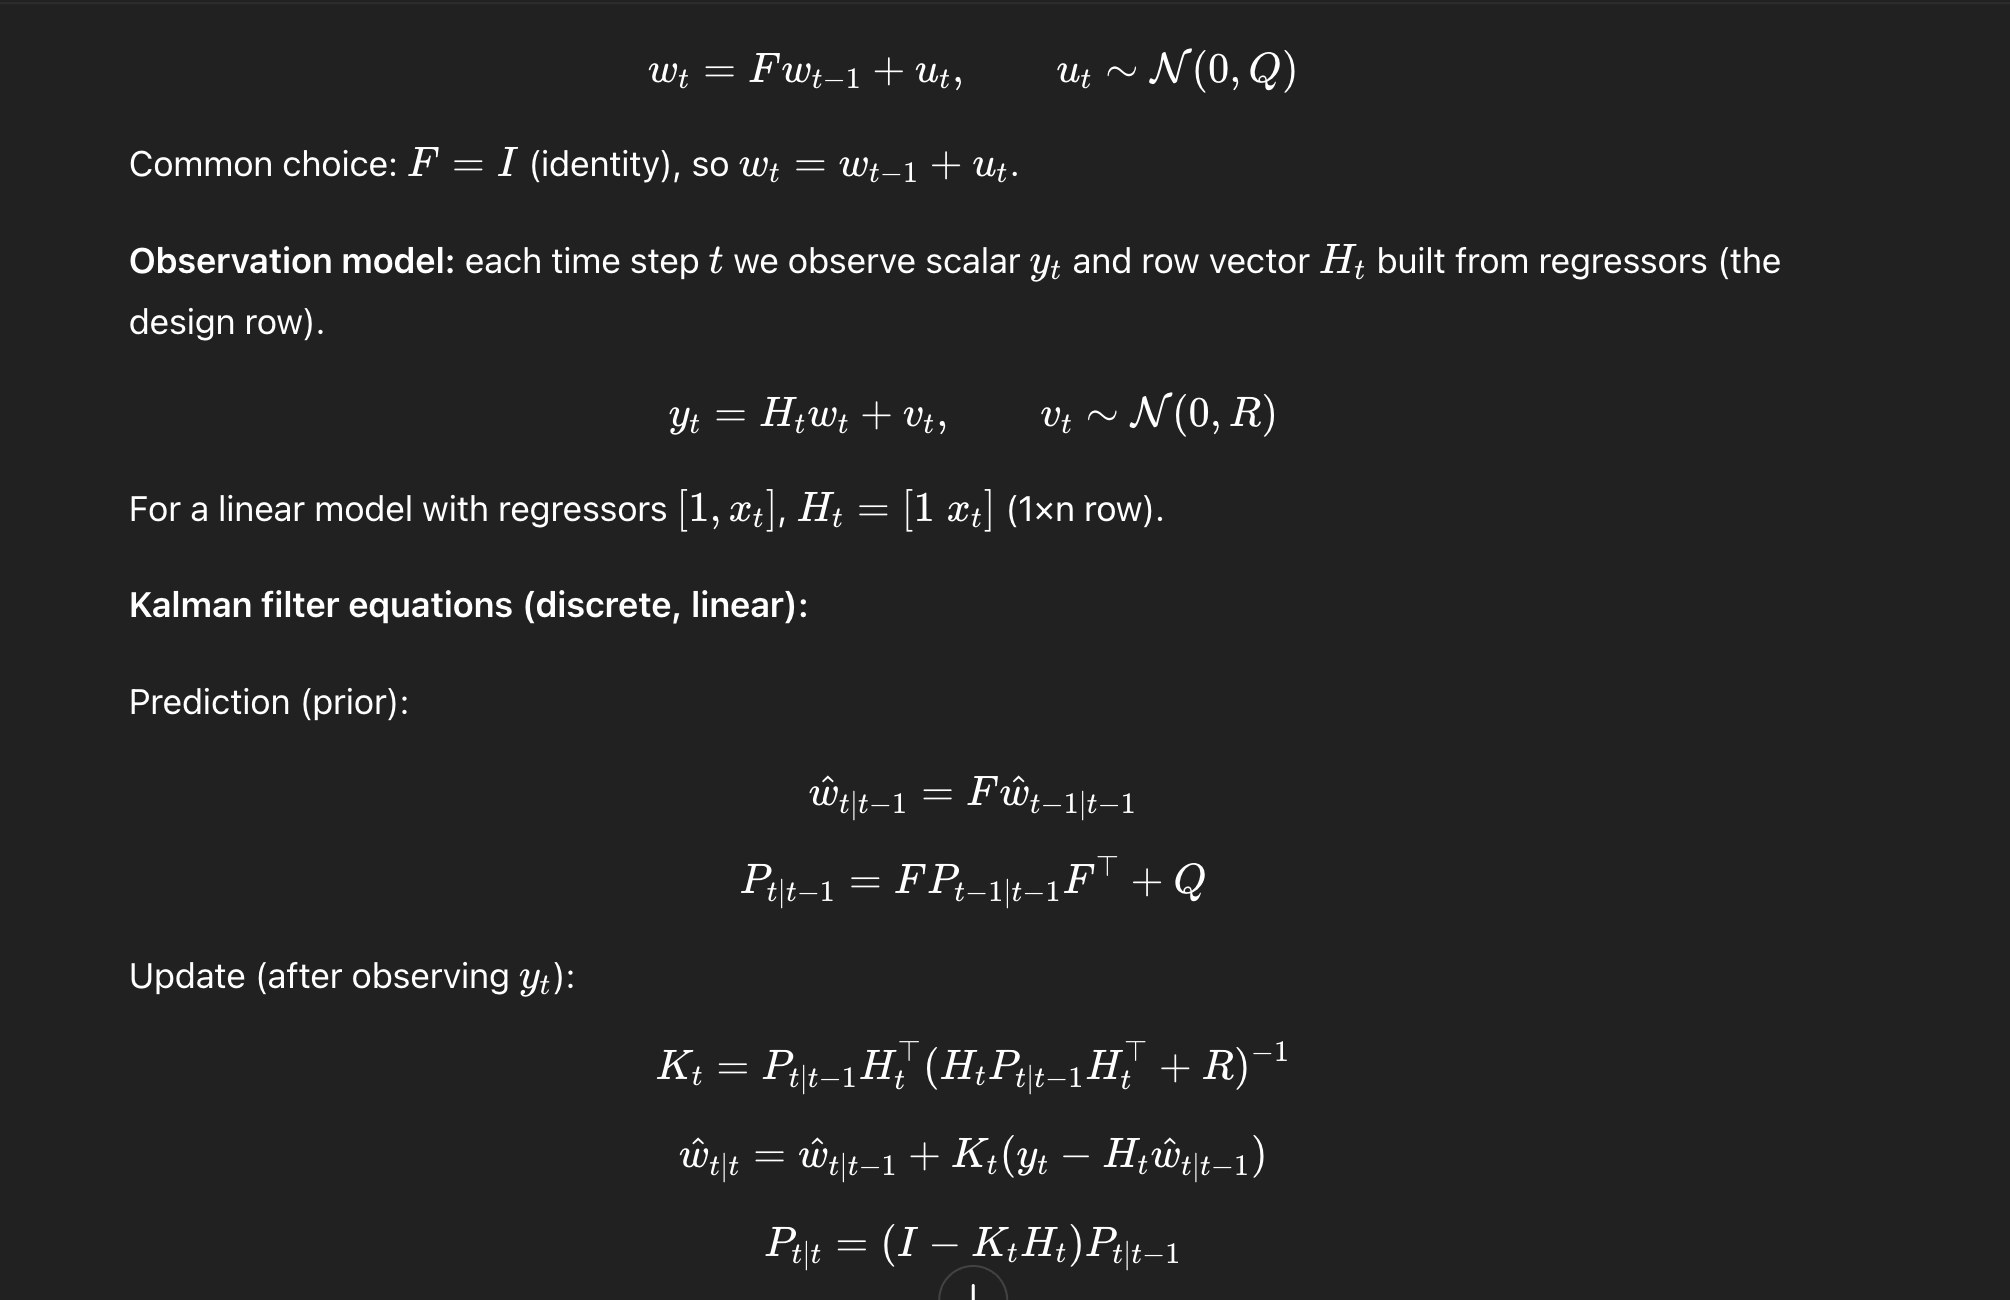

In [7]:
@nb.njit
def kalman_filter(x: np.ndarray, y: np.ndarray, R: float = 1.0, F: np.ndarray = None, Q: np.ndarray = None, P0: np.ndarray = None, w0: np.ndarray = None) -> np.ndarray:
    """ Perform Kalman Filter to estimate weights over time.
    """
    # Defining dimensions and initializing variables
    T, n = x.shape
    if F is None:
        F = np.eye(n)
    if P0 is None:
        P0 = np.eye(n) * 0.01
    if w0 is None:
        w0 = np.zeros(n)
    if Q is None:
        Q = np.eye(n) * 0.001

    w_t = w0.copy()
    P_t = P0.copy()
    w_kalman = np.zeros((T, n))
    
    for t in nb.prange(T):

        # Getting H_t vector
        H_t = x[t].reshape(1, -1)

        # Prediction step
        w_pred = F @ w_t
        P_pred = F @ P_t @ F.T + Q

        # Update step
        K_t = P_pred @ H_t.T @ np.linalg.inv(H_t @ P_pred @ H_t.T + R)
        w_t1 = w_pred + K_t @ (y[t] - H_t @ w_pred)
        P_upd = (np.eye(n) - K_t @ H_t) @ P_pred

        # Update variables for next iteration
        P_t = P_upd
        w_t = w_t1

        w_kalman[t, :] = w_t1

    return w_kalman

In [8]:
n = xl.shape[1]
R = 1.0
F = np.eye(n)
Q = np.eye(n) * 0.001
P_t = np.eye(n) * 0.1
w_t = np.zeros(n)

Kalman Filter MSE: 1.0795
Kalman Filter R^2: 0.9625


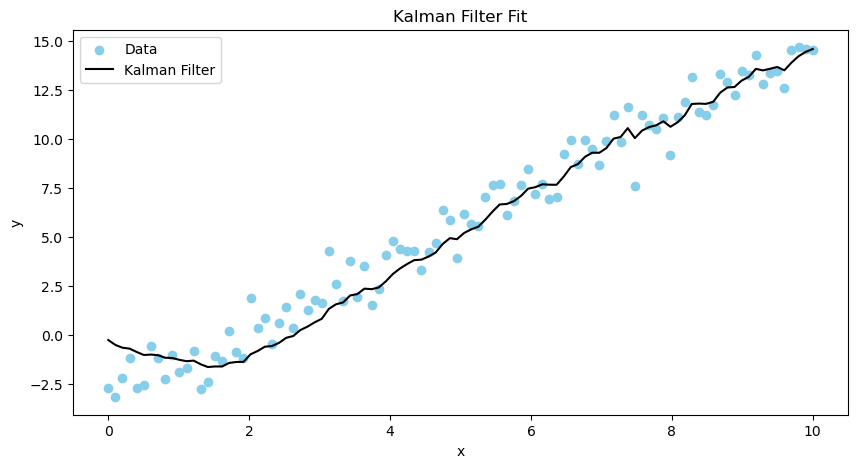

In [9]:
w_linear_kalman = kalman_filter(xl, yl, R, F, Q, P_t, w_t)
y_pred_kalman = np.array([xl[t] @ w_linear_kalman[t] for t in range(xl.shape[0])])
e_linear_kalman = mean_squared_error(yl, y_pred_kalman)
r2_linear_kalman = r2_score(yl, y_pred_kalman)
print(f'Kalman Filter MSE: {e_linear_kalman:.4f}')
print(f'Kalman Filter R^2: {r2_linear_kalman:.4f}')

plt.figure(figsize=(10, 5))
plt.scatter(xl[:,1], yl, label='Data', color='skyblue')
plt.plot(xl[:,1], y_pred_kalman, label='Kalman Filter', color='black')
plt.title('Kalman Filter Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Kalman Filter MSE: 3.1290
Kalman Filter R^2: 0.9880


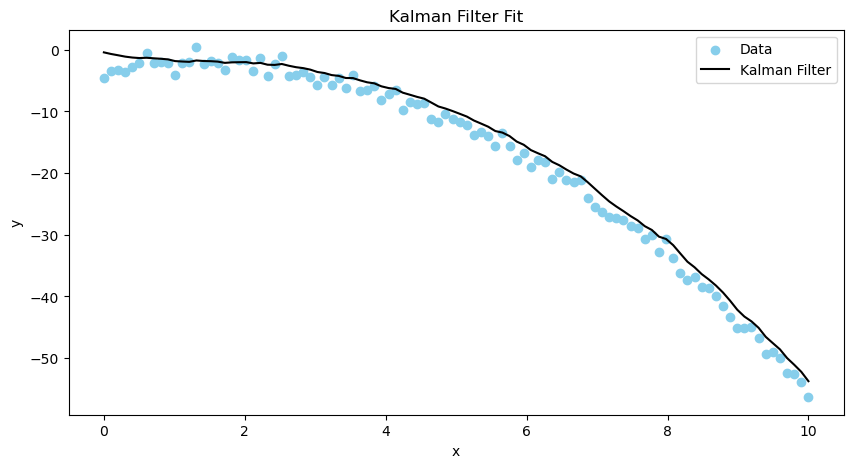

In [10]:
w_quad_kalman = kalman_filter(xq, yq, R, F, Q, P_t, w_t)
y_pred_kalman = np.array([xq[t] @ w_quad_kalman[t] for t in range(xq.shape[0])])
e_quad_kalman = mean_squared_error(yq, y_pred_kalman)
r2_quad_kalman = r2_score(yq, y_pred_kalman)
print(f'Kalman Filter MSE: {e_quad_kalman:.4f}')
print(f'Kalman Filter R^2: {r2_quad_kalman:.4f}')

plt.figure(figsize=(10, 5))
plt.scatter(xq[:,1], yq, label='Data', color='skyblue')
plt.plot(xq[:,1], y_pred_kalman, label='Kalman Filter', color='black')
plt.title('Kalman Filter Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## <font color='cornflowerblue'> Results

In [11]:
metrics_df = pd.DataFrame({
    'MSE': [e_linear, e_linear_kalman, e_quad, e_quad_kalman],
    'R^2': [r2_linear, r2_linear_kalman, r2_quad, r2_quad_kalman]
}).set_index(pd.Index(['Linear Data', 'Kalman Linear', 'Quad Data', 'Kalman Quad']))

metrics_df

,MSE,R^2
Linear Data,0.814905,0.971689
Kalman Linear,1.079522,0.962496
Quad Data,30.182745,0.883863
Kalman Quad,3.129029,0.987960


In [12]:
weights_df = pd.DataFrame({
    'Linear Weights': w_linear,
    'Quadratic Weights': w_quad
}).set_index(pd.Index(['w_0', 'w_1']))
weights_df.T

,w_0,w_1
Linear Weights,-3.382813,1.813793
Quadratic Weights,8.351041,-5.197983


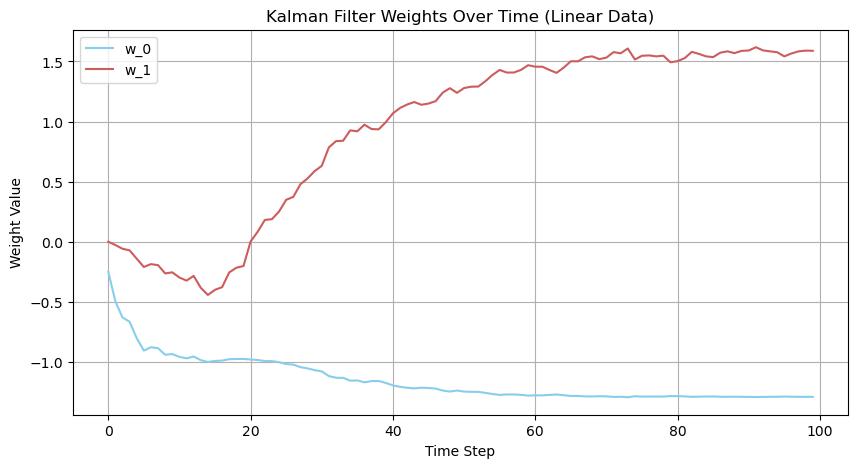

In [13]:
plt.figure(figsize=(10, 5))
for i in range(w_linear_kalman.shape[1]):
    plt.plot(w_linear_kalman[:, i], label=f'w_{i}', color=colors[i])
plt.title('Kalman Filter Weights Over Time (Linear Data)')
plt.xlabel('Time Step')
plt.ylabel('Weight Value')
plt.legend()
plt.grid()
plt.show()

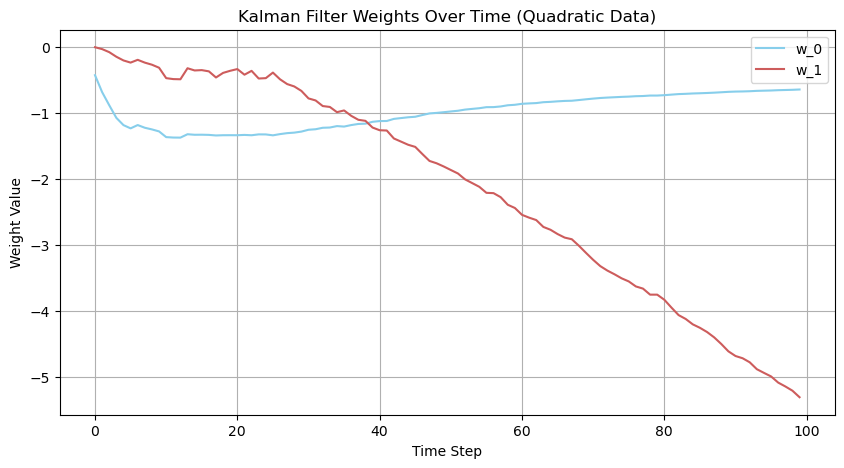

In [14]:
plt.figure(figsize=(10, 5))
for i in range(w_quad_kalman.shape[1]):
    plt.plot(w_quad_kalman[:, i], label=f'w_{i}', color=colors[i])
plt.title('Kalman Filter Weights Over Time (Quadratic Data)')
plt.xlabel('Time Step')
plt.ylabel('Weight Value')
plt.legend()
plt.grid()
plt.show()